# Trabajo Computacional 3

In [3]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import copy
import random
from __future__ import print_function
import community  #se usa para particion Louvain
import os
import numpy as np
import rpy2.robjects as robjects #se usa para infomap 

In [4]:
def ldata(archive):
    f=open(archive)
    data=[]
    for line in f:
        line=line.strip()
        col=line.split()
        data.append(col)
    return data

G=nx.read_gml("dolphins.gml")
genero=ldata("dolphinsGender.txt")

In [5]:
#Esto lo usamos para calcular modularidad 
#import igraph as igraph
#import networkx as nx
import time

def calculate_infomap(np_adj_list, method="infomap"):
    g = igraph.Graph.Weighted_Adjacency(np_adj_list.tolist(),mode=igraph.ADJ_UPPER)
   
    t0=time.time()
    if method=="infomap":
        labels = g.community_infomap(edge_weights="weight").membership
#    labels = g.community_label_propagation(weights="weight").membership
    if method=="fastgreedy":
        labels = g.community_fastgreedy(edge_weights="weight").membership
   
    print("Duración: {}s".format(time.time()-t0))
           
    return labels

from __future__ import division

from functools import wraps
from itertools import product

import networkx as nx
from networkx import NetworkXError
from networkx.utils import not_implemented_for
from networkx.algorithms.community.community_utils import is_partition

__all__ = ['coverage', 'modularity', 'performance']


class NotAPartition(NetworkXError):
    """Raised if a given collection is not a partition.

    """

    def __init__(self, G, collection):
        msg = '{} is not a valid partition of the graph {}'
        msg = msg.format(G, collection)
        super(NotAPartition, self).__init__(msg)


def modularity(G, communities, weight='weight'):
    r"""Returns the modularity of the given partition of the graph.

    Modularity is defined in [1]_ as

    .. math::

        Q = \frac{1}{2m} \sum_{ij} \left( A_{ij} - \frac{k_ik_j}{2m}\right)
            \delta(c_i,c_j)

    where $m$ is the number of edges, $A$ is the adjacency matrix of
    `G`, $k_i$ is the degree of $i$ and $\delta(c_i, c_j)$
    is 1 if $i$ and $j$ are in the same community and 0 otherwise.

    Parameters
    ----------
    G : NetworkX Graph

    communities : list
        List of sets of nodes of `G` representing a partition of the
        nodes.

    Returns
    -------
    Q : float
        The modularity of the paritition.

    Raises
    ------
    NotAPartition
        If `communities` is not a partition of the nodes of `G`.

    Examples
    --------
    >>> G = nx.barbell_graph(3, 0)
    >>> nx.algorithms.community.modularity(G, [{0, 1, 2}, {3, 4, 5}])
    0.35714285714285704

    References
    ----------
    .. [1] M. E. J. Newman *Networks: An Introduction*, page 224.
       Oxford University Press, 2011.

    """
    if not is_partition(G, communities):
        raise NotAPartition(G, communities)

    multigraph = G.is_multigraph()
    directed = G.is_directed()
    m = G.size(weight=weight)
    if directed:
        out_degree = dict(G.out_degree(weight=weight))
        in_degree = dict(G.in_degree(weight=weight))
        norm = 1 / m
    else:
        out_degree = dict(G.degree(weight=weight))
        in_degree = out_degree
        norm = 1 / (2 * m)

    def val(u, v):
        try:
            if multigraph:
                w = sum(d.get(weight, 1) for k, d in G[u][v].items())
            else:
                w = G[u][v].get(weight, 1)
        except KeyError:
            w = 0
        # Double count self-loops if the graph is undirected.
        if u == v and not directed:
            w *= 2
        return w - in_degree[u] * out_degree[v] * norm

    Q = sum(val(u, v) for c in communities for u, v in product(c, repeat=2))
    return Q * norm



In [6]:
def Silhouette1(lista,G):# para la primera particion, primer cluster
    F=lista[0] #primera particion
    b=[]
    a=[]
    S=[]
    for i in F[0]: #F0 es primer cluster, i nodo de ese cluster
        A=[]
        for j in F[0]:
            if i!=j:
                A.append(nx.shortest_path_length(G, source=i, target=j, weight=None))
        a.append(sum(A)/len(A))
        B=[]
        for k in F[1]: #F1 es el segundo cluster, k nodo
            B.append(nx.shortest_path_length(G, source=i, target=k, weight=None))
        b.append(sum(B)/len(B))
    for i in range(len(a)):
        m=max(a[i],b[i])
        s=(b[i]-a[i])/m
        S.append(s)
    return S 

In [7]:
def Silhouette(lista,G): 
    S=[]
    for l in range(len(lista)-1):  # me muevo en particiones 
        F=lista[l] # es la partición l-ésima
        S_l=[] #lista de silhouette para la partición l
        for c in range(len(F)):    # me muevo en cluster dentro de esa partición
            b=[]
            a=[]
            S_c=[]  #lista de silhouette para el cluster c de la partición l
            for i in F[c]: # me muevo dentro del cluster c, i nodo
                A=[]
                for j in F[c]:
                    if i!=j:
                        A.append(nx.shortest_path_length(G, source=i, target=j, weight=None))
                if len(A)!=0:
                    a.append(sum(A)/len(A))
                b1=[]
                for k in range(len(F)):
                      if k!=c:
                        B=[]
                        for z in F[k]: # me muevo dentro del cluster k
                            B.append(nx.shortest_path_length(G, source=i, target=z, weight=None))
                        b1.append(sum(B)/len(B))
                b.append(min(b1))
            for i in range(len(a)):
                m=max(a[i],b[i])
                s=(b[i]-a[i])/m
                S_c.append(s)
            S_l.append(S_c)
        S.append(S_l)
    return S
        

In [8]:
def Silhouette2(lista,G): 
    S_l=[] #lista de silhouette para la partición l
    for c in range(len(lista)):    # me muevo en cluster dentro de esa partición
        b=[]
        a=[]
        S_c=[]  #lista de silhouette para el cluster c de la partición l
        for i in lista[c]: # me muevo dentro del cluster c, i nodo
            A=[]
            for j in lista[c]:
                if i!=j:
                    A.append(nx.shortest_path_length(G, source=i, target=j, weight=None))
            if len(A)!=0:
                a.append(sum(A)/len(A))
            b1=[]
            for k in range(len(lista)):
                  if k!=c:
                    B=[]
                    for z in lista[k]: # me muevo dentro del cluster k
                        B.append(nx.shortest_path_length(G, source=i, target=z, weight=None))
                    b1.append(sum(B)/len(B))
            b.append(min(b1))
        for i in range(len(a)):
            m=max(a[i],b[i])
            s=(b[i]-a[i])/m
            S_c.append(s)
        S_l.append(sorted(S_c))
    return S_l

# Edge betweenness

In [41]:
#edge-betweenness
com = nx.algorithms.community.centrality.girvan_newman(G)
a=[nodos for nodos in com]


In [10]:
print(type(com),type(a)) 

<class 'generator'> <class 'list'>


In [42]:
F=[]                    ##F va a ser el nuevo vector de nodo-genero pero ordenando los nodos de la misma manera que lo hace nx
for n in G.nodes():
    for k in Cluster:
        if k[0]==n:
            F.append([k[0],k[1]])

In [43]:
modular=[]
for i in range(len(a)):
    modular.append([modularity(G,[cluster for cluster in a[i]]),i])

In [44]:
sorted(modular,reverse=True)

[[0.5193821446936424, 3],
 [0.5175625964162802, 5],
 [0.513923499861555, 4],
 [0.4938095803172331, 7],
 [0.4907242593251837, 6],
 [0.4895573751038319, 8],
 [0.4852853921917634, 9],
 [0.4804596337170197, 10],
 [0.4754163205569389, 11],
 [0.47035322969819165, 12],
 [0.465270361140777, 13],
 [0.4609192674340408, 14],
 [0.45807127882599347, 2],
 [0.45557928879395554, 15],
 [0.44930975831652187, 16],
 [0.4390649104070247, 17],
 [0.42707962501483293, 18],
 [0.41477789644396934, 19],
 [0.40558126656382265, 20],
 [0.3948221984889839, 21],
 [0.38540801392350005, 22],
 [0.38149202958743744, 1],
 [0.37870337407539306, 0],
 [0.37615205094735205, 23],
 [0.36590720303785484, 24],
 [0.35554368893635563, 25],
 [0.337625093944069, 26],
 [0.3220798227918202, 27],
 [0.31159764249831906, 28],
 [0.29951346861279243, 29],
 [0.2934219374233616, 30],
 [0.28311775641786335, 31],
 [0.2628060598868716, 32],
 [0.2486847830386456, 33],
 [0.23784660416913883, 34],
 [0.22241999920889194, 35],
 [0.20988093825402446, 

In [45]:
Cluster=[] #la particion con mas modularidad de edge betweeness
b=0
Color=["r","g","b","y","k"]
for c in a[3]:
    for n in a[3][b]:
        Cluster.append([n,Color[b]])
        
    b+=1


In [46]:
Cluster2=[] #particion 2 de edge bet
b=0
Color=["r","g","b","y","k"]
for c in a[2]:
    for n in a[2][b]:
        Cluster2.append([n,Color[b]])
        
    b+=1


In [14]:
S=Silhouette(a,G)
S

[[[0.43495762711864405,
   0.3134615384615385,
   0.45705128205128204,
   0.5242187500000001,
   0.454,
   0.43495762711864405,
   0.42249999999999993,
   0.5634210526315789,
   0.46953125,
   0.455188679245283,
   0.5625,
   0.42564102564102557,
   0.1313636363636364,
   0.5132812499999999,
   0.53515625,
   0.46417525773195867,
   0.4383720930232558,
   0.3053846153846154,
   0.53515625,
   0.2953947368421053,
   0.47051282051282045,
   0.5976635514018692,
   0.06375000000000008,
   0.4505813953488372,
   0.39563953488372083,
   0.2608552631578948,
   0.4421875,
   0.5132812499999999,
   0.4203125,
   0.5682242990654205,
   0.021590909090909015,
   0.4210280373831775,
   0.5237113402061855,
   0.5037109375,
   0.49090909090909096,
   0.41666666666666663,
   0.41121495327102797,
   0.4473684210526316,
   0.536046511627907,
   0.5055232558139535,
   0.4261627906976744],
  [0.5336909871244635,
   0.42980132450331127,
   0.49817708333333327,
   0.641747572815534,
   0.33870967741935487,


Silhouette promedio es con todos los nodos por igual. Podríamos ver el S promedio para cada cluster y ver que tan distintos (esperaríamos que sean parecidos si es una buena partición). Podríamos ver gráficos.

http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-download-auto-examples-cluster-plot-kmeans-silhouette-analysis-py

http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_samples.html#sklearn.metrics.silhouette_samples

https://python-louvain.readthedocs.io/en/latest/api.html#community.generate_dendrogram esto es de Louvain 

# Louvain

In [15]:
# Louvain
partition = community.best_partition(G)
partition 

{'Beak': 0,
 'Beescratch': 1,
 'Bumper': 0,
 'CCL': 2,
 'Cross': 3,
 'DN16': 1,
 'DN21': 1,
 'DN63': 0,
 'Double': 2,
 'Feather': 1,
 'Fish': 0,
 'Five': 3,
 'Fork': 4,
 'Gallatin': 1,
 'Grin': 4,
 'Haecksel': 3,
 'Hook': 4,
 'Jet': 1,
 'Jonah': 3,
 'Knit': 0,
 'Kringel': 4,
 'MN105': 3,
 'MN23': 1,
 'MN60': 3,
 'MN83': 3,
 'Mus': 1,
 'Notch': 1,
 'Number1': 1,
 'Oscar': 2,
 'Patchback': 3,
 'PL': 0,
 'Quasi': 1,
 'Ripplefluke': 1,
 'Scabs': 4,
 'Shmuddel': 4,
 'SMN5': 3,
 'SN100': 2,
 'SN4': 4,
 'SN63': 4,
 'SN89': 2,
 'SN9': 4,
 'SN90': 1,
 'SN96': 0,
 'Stripes': 4,
 'Thumper': 4,
 'Topless': 3,
 'TR120': 4,
 'TR77': 0,
 'TR82': 1,
 'TR88': 4,
 'TR99': 4,
 'Trigger': 3,
 'TSN103': 4,
 'TSN83': 4,
 'Upbang': 1,
 'Vau': 3,
 'Wave': 1,
 'Web': 1,
 'Whitetip': 4,
 'Zap': 2,
 'Zig': 1,
 'Zipfel': 4}

In [16]:
print(type(partition))

<class 'dict'>


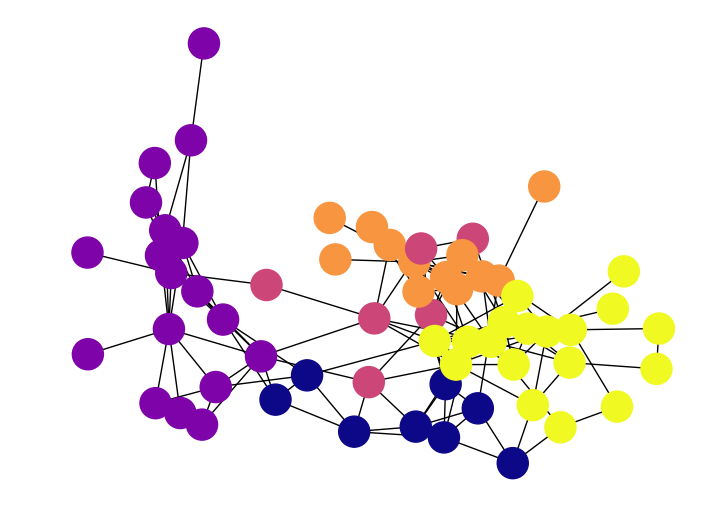

In [39]:
nx.draw(G,
        cmap=plt.get_cmap('plasma'),
        node_color=list(partition.values()),
        node_size=500,
        alpha=1)

plt.show()

In [17]:
o=[]
for j in G.nodes():
    o.append(partition[j])
set(o)

{0, 1, 2, 3, 4}

In [24]:
cluster=[0,1,2,3,4]
A=[] #armamos la lista de la partición a partir de Louvain
for i in cluster:
    a=[]
    for j in G.nodes():
        if partition[j]==i:
            a.append(j)
    A.append(a)

In [25]:
k=0
for i in A:
    for j in i:
        k+=1
k

62

In [26]:
modularity(G,[cluster for cluster in A]) #Louvain modularidad

0.5188283691309657

Comparar comunidades:
    Overlap?
    Testear con la comunidad M-F?
    
Modularidad con recableo

In [27]:

SilL=Silhouette2(A,G)
SilouL=[]
SCL=[]
Color=["r","g","b","y","m","c"]
b=0
for i in SilL:
    for j in i:
        SCL.append(Color[b])
        SilouL.append(j)
    b+=1

In [28]:
k=0
for j in SilL:
    for i in j:
        k+=1
k

62

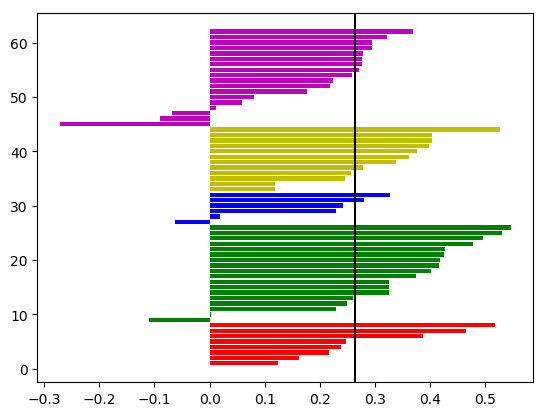

In [29]:
# Graficando siloutte Louvain
plt.rcdefaults()
fig, ax = plt.subplots()


y_pos = np.arange(1,63)
sil= SilouL
ax.barh(y_pos, sil, align='center',
        color=SCL)

plt.axvline(sum(sil)/len(sil),c="k")
plt.show()

# Fast Greedy

In [30]:
# Fastgreedy

comus = nx.algorithms.community.greedy_modularity_communities(G, weight=None)


In [31]:
B=[] #Partición obtenida con fastgreedy
for j in comus:
    a=[]
    for i in j:
        a.append(i)
    B.append(a)

In [32]:
modularity(G,[cluster for cluster in B]) #Fastgreedy modularidad

0.4954906847039279

In [33]:
SilF=Silhouette2(B,G)
SilouF=[]
SCF=[]
Color=["r","g","b","y"]
b=0
for i in SilF:
    for j in i:
        SCF.append(Color[b])
        SilouF.append(j)
    b+=1

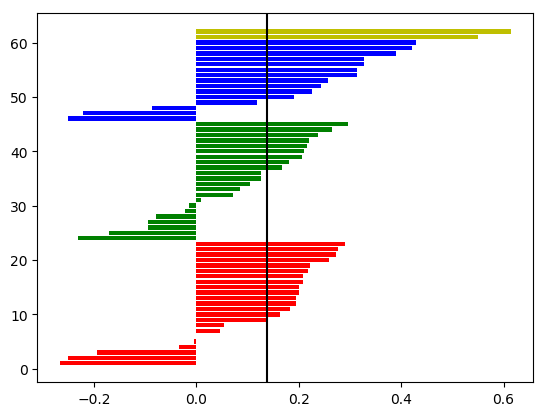

In [34]:
# Graficando siloutte Fastgreedy
plt.rcdefaults()
fig, ax = plt.subplots()


y_pos = np.arange(1,63)
sil= SilouF
ax.barh(y_pos, sil, align='center',
        color=SCF)

plt.axvline(sum(sil)/len(sil),c="k")
plt.show()

# Infomap

In [37]:
#funcion para infomap
def community(nxG, algorithm, fig_name = "G"):
    """
    In:
        nxG: grafo de networkx.
        algorithm: string, entre las siguientes opciones: 
            fast_greedy
            edge_betweenness
            louvain
            infomap
        fig_name: nombre de la figura que se genera al clsuterizar. Le agrega automaticamente el nombre del algoritmo usado y el nombre del grafo si lo tuviere
    Out:
        labels: numpy array con la pertenencia de cada nodo al cluster.
    
    """
    gml_file_name = "G.gml"
    fig_name += "_"+nxG.name+"_"+algorithm+".svg"
    nx.write_gml(nxG, gml_file_name)
    
    igG = robjects.r('''
        f <- function(file, algorithm, fig_name){
            require("igraph")     
            
            G <- read.graph(file, "gml")
            #format = c("edgelist", "pajek", "ncol", "lgl", "graphml","dimacs", "graphdb", "gml", "dl"), ...)
            
            if(algorithm == "fast_greedy"){
                c <- fastgreedy.community(G)
                #c <- cluster_fast_greedy(G, merges = TRUE, modularity = TRUE, membership = TRUE)
            }
            
            if(algorithm == "edge_betweenness"){
                c <- edge.betweenness.community(G)
                #c <- cluster_edge_betweenness(G,directed = FALSE,edge.betweenness = TRUE)
            }
            
            if(algorithm == "louvain"){
                c <- multilevel.community(G)
                #c <- cluster_louvain(G)
            }
            
            if(algorithm == "infomap"){
                #c <- cluster_infomap(G)
                c <- infomap.community(G)
            }
            
            svg(fig_name)
            plot(c, G)
            dev.off()
            
            return(membership(c))
        }
    ''')
    
    labels = igG(gml_file_name, algorithm, fig_name)
    os.remove(gml_file_name)
    return np.array(labels)

In [38]:
Z=community(G, "infomap", fig_name = "G")

RRuntimeError: Error in read.graph(file, "gml") : could not find function "read.graph"


In [35]:
Z

array([ 1.,  5.,  1.,  1.,  4.,  1.,  5.,  3.,  3.,  2.,  2.,  1.,  4.,
        2.,  3.,  5.,  4.,  1.,  4.,  2.,  5.,  3.,  4.,  1.,  2.,  2.,
        2.,  2.,  3.,  5.,  2.,  3.,  1.,  3.,  3.,  1.,  3.,  2.,  1.,
        1.,  2.,  1.,  3.,  4.,  6.,  6.,  2.,  1.,  2.,  3.,  1.,  4.,
        1.,  1.,  2.,  1.,  3.,  1.,  1.,  2.,  1.,  2.])

In [21]:
ClusterNodo=[]
m=0
for i in G.nodes():
    ClusterNodo.append([Z[m],i])
    m+=1
sorted(ClusterNodo)

C=[]
for i in set(Z):
    c=[]
    for k in ClusterNodo:
        if k[0]==i:
            c.append(k[1])
    C.append(c)

In [25]:
SilI=Silhouette2(C,G)
SilouI=[]
SCI=[]
Color=["r","g","b","y","m","c"]
b=0
for i in SilI:
    for j in i:
        SCI.append(Color[b])
        SilouI.append(j)
    b+=1

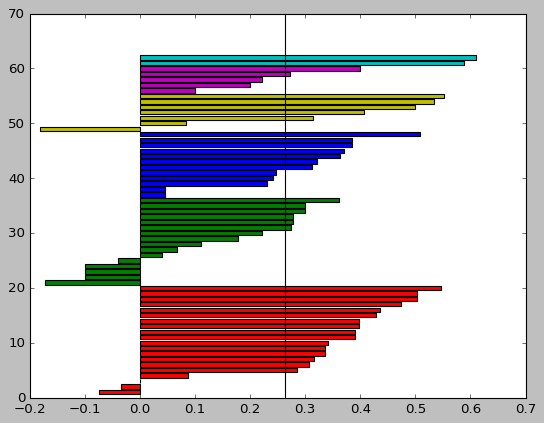

In [28]:
# Graficando siloutte Infomap
plt.rcdefaults()
fig, ax = plt.subplots()


y_pos = np.arange(1,63)
sil= SilouI
ax.barh(y_pos, sil, align='center',
        color=SCI)

plt.axvline(sum(sil)/len(sil),c="k")
plt.show()

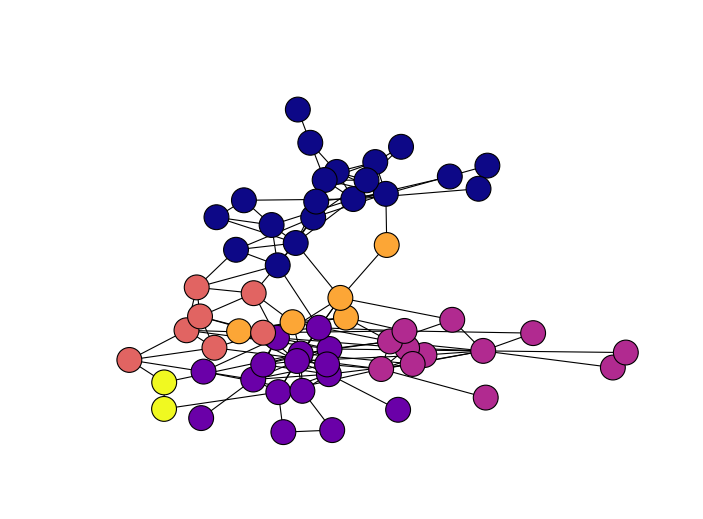

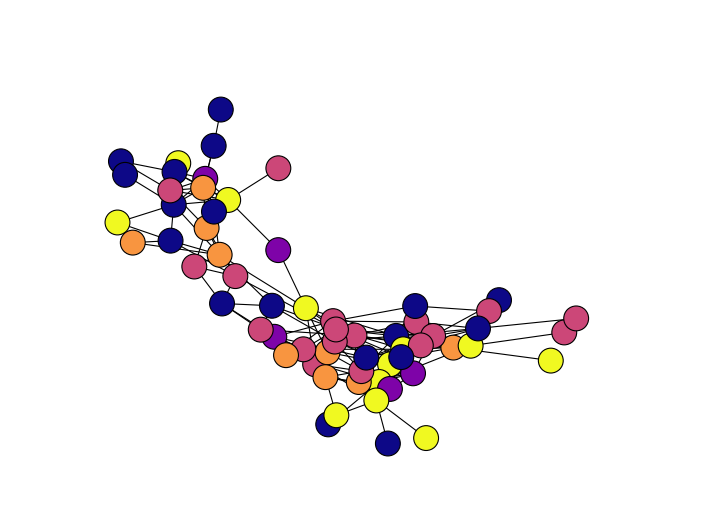

In [54]:

nx.draw(G,
        cmap=plt.get_cmap('plasma'),
        node_color=Z,
        node_size=500,
        alpha=1)

plt.show()




b.
Caracterice  las  particiones  obtenidas  en  términos  de  modularidad  y  silouhette
de  cada 
particion
.
Compare con valores esperados en redes recableadas
y establezca si tiene derecho a 
llamar modular a esta red.
c.
C
aracterice cuantitativamente
el acuerdo entre las 
particiones obtenidas
utilizando 
uno o más 
de los observables vistos en clase.
d.
Analice 
cuantitativamente 
la  relación 
entre  el  género  de  los  delfines  y  la  estructura  de 
comunidades  del  grupo. 
Puede  utilizar  para  ello,  por
ejemplo,  tests  de  sobre
-
representación
y/o  sub
-
representacion
.
Qué 
hipótesis
p
uede  aventurar 
sobre  propiedades  comportamentales 
de este grupo de delfines a partir de 
lo enc
ontrado?
2)
[optativo]  Implemente  un  algoritmo  de  reconocimiento  de  comunas  basado  en  la  metodología  de 
percolación de cliques. 
Qué individuos son los 
más sociables de la comunidad?

In [131]:
import igraph as igraph
def clusterize(nx_Graph, method="infomap"): ##Me anduvo esto
    """
    Calcula el agrupamiento en comunidades de un grafo.
    
    In:
        nx_Graph: grafo de networkx
        method: metodo de clustering, puede ser: "infomap", "fastgreedy", "eigenvector", "louvain", "edge_betweenness","label_prop", "walktrap", ""
        
    Out:
        labels_dict: diccionario de nodo : a label al cluster al que pertenece.
    """
    if method == "edge_betweenness":
        nx_Graph = max(nx.connected_component_subgraphs(nx_Graph), key=len)#se queda con la componente más grande.
        print("AVISO: restringiendo a la componente connexa más grade. De otro modo falla el algoritmo de detección de comunidades edge_betweenness.")
    
    isdirected = nx.is_directed(nx_Graph)
    np_adj_list = nx.to_numpy_matrix(nx_Graph)
    g = igraph.Graph.Weighted_Adjacency(np_adj_list.tolist(),mode=igraph.ADJ_UPPER)
   
    if method=="infomap":
        labels = g.community_infomap(edge_weights="weight").membership
    if method=="label_prop":
        labels = g.community_label_propagation(weights="weight").membership
    if method=="fastgreedy":
        labels = g.community_fastgreedy(weights="weight").as_clustering().membership
    if method=="eigenvector":
        labels = g.community_leading_eigenvector(weights="weight").membership
    if method=="louvain":
        labels = g.community_multilevel(weights="weight").membership
    if method=="edge_betweenness":
        labels = g.community_edge_betweenness(weights="weight", directed=isdirected).as_clustering().membership
    if method=="walktrap":
        labels = g.community_walktrap(weights="weight").as_clustering().membership
    
    label_dict = {node:label for node,label in zip(nx_Graph.nodes(), labels)}
    return label_dict

In [138]:
def recableo(Grafo):
#     b=np.random.random_integers(1,Grafo.number_of_nodes()) #Creo que esto no tiene sentido. Conviene usar el b máximo que te deje
    b=160
    nx.double_edge_swap(Grafo,nswap=b,max_tries=3*b)
    return Grafo

In [139]:
def modularidad_recableada(Grafo,metodo,iteraciones):
    mod=[]
    for i in range(iteraciones):
        Gr=copy.deepcopy(Grafo)
        recableo(Gr) #Recableo de la red (dado por la función recableo)
        
        #modularidad Edge_betweenness
        if metodo=="edge_betweenness":
            com = nx.algorithms.community.centrality.girvan_newman(Gr)
            a=[nodos for nodos in com]
            modular=[]
            for i in range(len(a)):
                modular.append(modularity(Gr,[cluster for cluster in a[i]]))
            mod.append(sorted(modular,reverse=True)[0])
        
        #modularidad Louvain    
        if metodo=="louvain":
            partition = community.best_partition(Gr)
            A=[] #armamos la lista de la partición a partir de Louvain           
            for i in set(partition.values()):
                a=[]
                for j in Gr.nodes():
                    if partition[j]==i:
                        a.append(j)
                A.append(a)
            mod.append(modularity(Gr,[cluster for cluster in A]))
        
        #modularidad Fastgreedy
        if metodo=="fastgreedy":
            comus = nx.algorithms.community.greedy_modularity_communities(Gr, weight=None)
            B=[] #Partición obtenida con fastgreedy
            for j in comus:
                a=[]
                for i in j:
                    a.append(i)
                B.append(a)
            mod.append(modularity(Gr,[cluster for cluster in B]))
        
        #modularidad Infomap
        if metodo=="infomap":                        
            partition = clusterize(Gr, "infomap")
            C=[] #armamos la lista de la partición a partir de infomap
            for i in set(partition.values()):
                a=[]
                for j in Gr.nodes():
                    if partition[j]==i:
                        a.append(j)
                C.append(a)
            mod.append(modularity(Gr,[cluster for cluster in C]))

    return mod

In [140]:
#Lista de posibles modularidades para meter en modularidad_recableada
metodo=["edge_betweenness","louvain","fastgreedy","infomap"]

In [134]:
def creartxt(lista1,lista2,lista3,lista4,NombreArchivo):         ##Lo único que hay que decirle es las dos listas a guardar. Se podrían guardar más, pero hace falta agregar un par de cosas
    with open(NombreArchivo,'w') as f:             ##Nombre de archivo hay que ponerlo entre comillas y punto txt. Es el nombre que queremos que tenga el archivo
        a=0
        for item in lista1:
            f.write("{}\t{}\t{}\t{}\n".format(item,lista2[a],lista3[a],lista4[a]))
            a+=1
            
#LECTURA Para trabajar con los archivos txt de la carpeta DemoliendoRedes          
def leetxt(NombreArchivo):    ##Le ponés entre comillas y .txt el nombre del archivo y lo lee
    lectura1=[]               ##la función devuelve dos listas. la primera es la lista1 de arriba, la segunda la lista2
    lectura2=[]               ##Para aplicarla es poner f=leetxt("NombreArchivo.txt")
    lectura3=[]
    lectura4=[]
    with open(NombreArchivo, 'r') as f: ## f[0] va a ser lista1
        contenido= f.readlines()        ## f[1] va a ser lista2
        for x in contenido:             ## Al igual que la de arriba se puede extender fácil a más de dos listas
            row = x.split()
            lectura1.append(float(row[0]))
            lectura2.append(float(row[1]))
            lectura3.append(float(row[2]))
            lectura4.append(float(row[3]))
    return lectura1, lectura2, lectura3, lectura4

In [141]:
#armo el for para correr en los cuatro métodos
H=[] #va a contener la lista de modularidades random para cada uno de los metodos
for i in metodo:
    H.append(modularidad_recableada(G,i,1000))
creartxt(H[0],H[1],H[2],H[3],"Modularidades.txt")

In [136]:
H=leetxt("Modularidades.txt")

[]

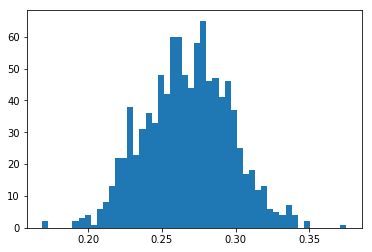

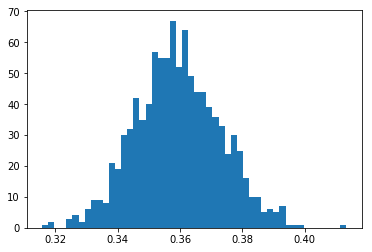

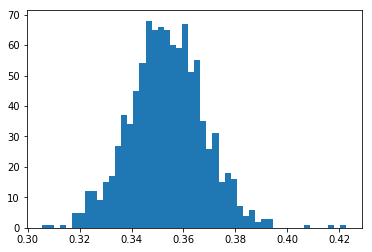

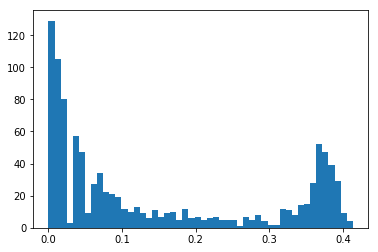

In [162]:
#graficamo las modularidades
b=50
#edge_betweenness
plt.hist(H[0],bins=b)
plt.show()
#louvain
plt.hist(H[1],bins=b)
plt.show()
#fastgreedy
plt.hist(H[2],bins=b)
plt.show()
#infomap
plt.hist(H[3],bins=b)
plt.show()

In [129]:
def entrega_lista(Gr,metodo):
    #Edge_betweenness
    if metodo=="edge_betweenness":
        com = nx.algorithms.community.centrality.girvan_newman(Gr)
        a=[nodos for nodos in com]
        modular=[]
        for i in range(len(a)):
            modular.append([modularity(Gr,[cluster for cluster in a[i]]),i])
        modular=sorted(modular,reverse=True)
        A=a[modular[0][1]]

    #modularidad Louvain    
    if metodo=="louvain":
        partition = community.best_partition(Gr)
        A=[] #armamos la lista de la partición a partir de Louvain
        o=[]
        for j in Gr.nodes():
            o.append(partition[j])            
        for i in set(o):
            a=[]
            for j in Gr.nodes():
                if partition[j]==i:
                    a.append(j)
            A.append(a)

    #modularidad Fastgreedy
    if metodo=="fastgreedy":
        comus = nx.algorithms.community.greedy_modularity_communities(Gr, weight=None)
        A=[] #Partición obtenida con fastgreedy
        for j in comus:
            a=[]
            for i in j:
                a.append(i)
            A.append(a)

    #modularidad Infomap
    if metodo=="infomap":
        partition = clusterize(Gr, "infomap")
        A=[] #armamos la lista de la partición a partir de Louvain
        o=[]
        for j in Gr.nodes():
            o.append(partition[j])            
        for i in set(o):
            a=[]
            for j in Gr.nodes():
                if partition[j]==i:
                    a.append(j)
            A.append(a)
            
    return A

In [179]:
def rep_gen(lista,diccionario):
    representacion_genero=[]
    for i in lista: ##lista es la lista de cluster en una partición donde aparecen los nombres de los nodos
        t=len(i)
        f=0
        m=0
        NA=0
        for j in i: ##Moverme en j implica recorrer todo el cluster
            if diccionario[j]=="f": ##Necesito generarme un diccionario donde yo ponga el nodo y aperzca el género
                f+=1
            if diccionario[j]=="m":
                m+=1
            if diccionario[j]=="NA":
                NA+=1
        representacion_genero.append([f,m,NA]) ##Me apendea a la lista la representación de género en cada cluster
    return representacion_genero

In [19]:
Dict_gen={i:j for i,j in genero} ##Diccionario con los generos. Le ponés el delfín, te tira el género

In [180]:
def gen_aleatorio(Genero):
    genero_shuffle=[]
    g=[]
    for i,j in Genero:
        g.append(j)
    random.shuffle(g)
    contador=0
    for i in G.nodes():
        genero_shuffle.append([i,g[contador]])
        contador+=1
    diccionario={m:n for m,n in genero_shuffle}
    return diccionario

In [181]:
#Corre bastante rápido

##Armemos el modelo nulo para la representacion por genero
Listas_cluster=[]
for i in metodo:
    Listas_cluster.append(entrega_lista(G,i))

Rep_gen_segun_metodo=[] ##Esta es la parte real de nuestra red para cada método
for lista in Listas_cluster:
    Rep_gen_segun_metodo.append(rep_gen(lista,Dict_gen))
##Veamos ahora el modelo nulo
iteraciones=1000
Rep_gen_aleatoria=[] ##El primer elemento va a tener una lista de listas (¿de listas?) correspondiente al primer método y así.
for lista in Listas_cluster:
    Rep_gen_aleatoria_lista=[]
    for i in range(iteraciones):
        dict_aleatorio=gen_aleatorio(genero) ##me genera diccionarios con la lista de generos aleatoria
        Rep_gen_aleatoria_lista.append(rep_gen(lista,dict_aleatorio))
    Rep_gen_aleatoria.append(Rep_gen_aleatoria_lista)

In [182]:
Rep_gen_segun_metodo[3]

[[13, 4, 1], [2, 10, 2], [3, 9, 0], [0, 8, 0], [2, 3, 0], [4, 0, 1]]

In [197]:
cluster_uno_infomap_f=[]
cluster_uno_infomap_m=[]
cluster_uno_infomap_NA=[]
for i in Rep_gen_aleatoria[3]:
    cluster_uno_infomap_f.append(i[0][0])
    cluster_uno_infomap_m.append(i[0][1])
    cluster_uno_infomap_NA.append(i[0][2])

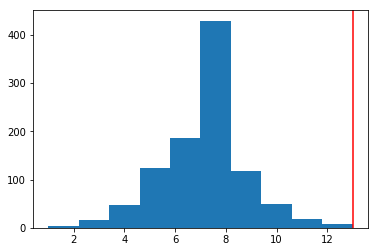

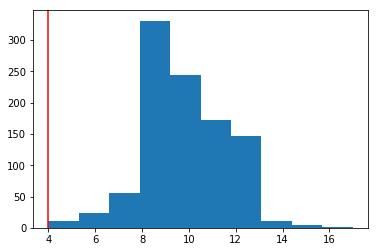

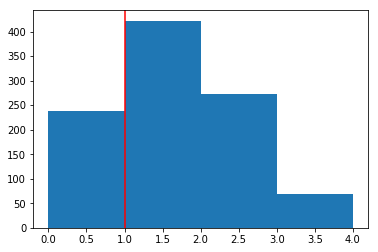

In [200]:
l=10
plt.hist(cluster_uno_infomap_f,bins=l)
plt.axvline(13,c="r")
plt.show()
plt.hist(cluster_uno_infomap_m,bins=l)
plt.axvline(4,c="r")
plt.show()
plt.hist(cluster_uno_infomap_NA,bins=4)
plt.axvline(1,c="r")
plt.show()

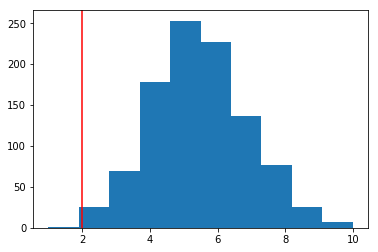

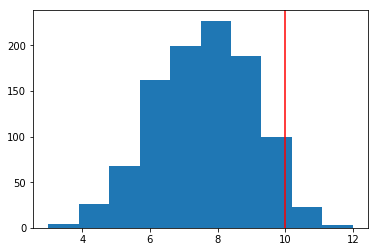

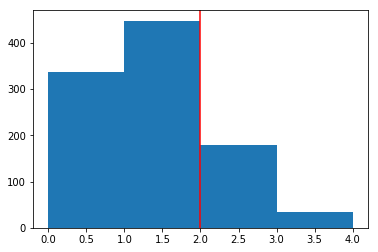

In [202]:
cluster_dos_infomap_f=[]
cluster_dos_infomap_m=[]
cluster_dos_infomap_NA=[]
for i in Rep_gen_aleatoria[3]:
    cluster_dos_infomap_f.append(i[1][0])
    cluster_dos_infomap_m.append(i[1][1])
    cluster_dos_infomap_NA.append(i[1][2])
    
plt.hist(cluster_dos_infomap_f,bins=l)
plt.axvline(2,c="r")
plt.show()
plt.hist(cluster_dos_infomap_m,bins=l)
plt.axvline(10,c="r")
plt.show()
plt.hist(cluster_dos_infomap_NA,bins=4)
plt.axvline(2,c="r")
plt.show()